# Task 2

## Can we predict the ratings from the text features taken from reviews?

In [12]:
!pip install pickle5
import pickle5
# import pickle
import pandas as pd
import numpy as np
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn import decomposition, ensemble
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, SpatialDropout1D, GRU, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import pandas, xgboost, numpy, textblob, string
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras import layers, models, optimizers
import multiprocessing
pd.set_option('display.max_columns', None)

base_dir = './'

In [16]:
def read_pickle(file):
    with open(file, 'rb') as f:
        data = pickle5.load(f)
    return data

In [18]:
reviews_df = read_pickle(base_dir + 'reviews_curtailed_4gb.pkl').reset_index()

# Following line is for debugging purposes to reduce the data set size.
# reviews_df = reviews_df[reviews_df.user_id.isin(reviews_df.groupby('user_id')['business_id'].count().sort_values(ascending=False).nlargest(50).reset_index().user_id)]

reviews_df = reviews_df[['text', 'stars']]
reviews_df.head()

,text,stars
0,I love Deagan's. I do. I really do. The atmosp...,5.0
1,"Oh happy day, finally have a Canes near my cas...",4.0
2,This is definitely my favorite fast food sub s...,5.0
3,"Really good place with simple decor, amazing f...",5.0
4,"Awesome office and staff, very professional an...",5.0


**Distribution of review ratings**

In [19]:
reviews_df.groupby('stars')['text'].count()

stars
1.0     958596
2.0     419709
3.0     534070
4.0    1085187
5.0    2726027
Name: text, dtype: int64

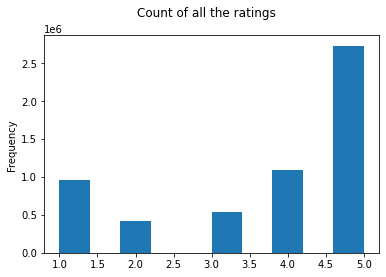

In [20]:
_ = reviews_df['stars'].plot(kind='hist',subplots=True,sharex=True,sharey=True,title="Count of all the ratings")

In [21]:
downsampling_n = sorted(list(reviews_df.stars.value_counts()))[0]
fn = lambda row: row.loc[np.random.choice(row.index, downsampling_n, replace=True),:]
reviews_df = reviews_df.groupby('stars', as_index=False).apply(fn)

In [22]:
reviews_df.groupby('stars')['text'].count()

stars
1.0    419709
2.0    419709
3.0    419709
4.0    419709
5.0    419709
Name: text, dtype: int64

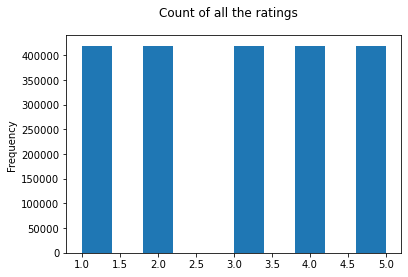

In [23]:
_ = reviews_df['stars'].plot(kind='hist',subplots=True,sharex=True,sharey=True,title="Count of all the ratings")

Splitting the data into train and test sets

Converting the labels into one hot encodings

In [24]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(reviews_df['text'], reviews_df['stars'])

encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

Generating the combination of TF-IDF features parallelly (to save time)

In [25]:
import multiprocessing
manager = multiprocessing.Manager()
data_dict = manager.dict({})
def f1(data_dict):
    # word level tf-idf
    tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
    tfidf_vect.fit(reviews_df['text'])
    xtrain_tfidf =  tfidf_vect.transform(train_x)
    xvalid_tfidf =  tfidf_vect.transform(valid_x)
    data_dict["xtrain_tfidf"] = xtrain_tfidf
    data_dict["xvalid_tfidf"] = xvalid_tfidf
    print("f1")

def f2(data_dict):
    # ngram level tf-idf 
    tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
    tfidf_vect_ngram.fit(reviews_df['text'])
    xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
    xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)
    data_dict["xtrain_tfidf_ngram"] = xtrain_tfidf_ngram
    data_dict["xvalid_tfidf_ngram"] = xvalid_tfidf_ngram
    print("f2")

def f4(data_dict):
    # create a count vectorizer object 
    count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
    count_vect.fit(reviews_df['text'])
    # transform the training and validation data using count vectorizer object
    xtrain_count =  count_vect.transform(train_x)
    xvalid_count =  count_vect.transform(valid_x)
    data_dict["xtrain_count"] = xtrain_count
    data_dict["xvalid_count"] = xvalid_count
    print("f4")

p1 = multiprocessing.Process(target=f1, args=(data_dict,))
p2 = multiprocessing.Process(target=f2, args=(data_dict,))
p4 = multiprocessing.Process(target=f4, args=(data_dict,))

p1.start()
p2.start()
p4.start()

p1.join()
p2.join()
p4.join()

# Can't process the Character level in background because the output vector is too large to store in Manager dictionary.
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(reviews_df['text'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x)

print("f3")

f4
f1
f2


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:501: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'token_pattern' will not be used"


f3


Extract the parallely generated TF-IDF features

In [26]:
xtrain_tfidf = data_dict["xtrain_tfidf"]
xvalid_tfidf = data_dict["xvalid_tfidf"]

xtrain_tfidf_ngram = data_dict["xtrain_tfidf_ngram"]
xvalid_tfidf_ngram = data_dict["xvalid_tfidf_ngram"]

xtrain_count = data_dict["xtrain_count"]
xvalid_count = data_dict["xvalid_count"]

Generate the Embedding matrix and document vectors

In [ ]:
embeddings_index = {}
for i, line in enumerate(open(base_dir + 'wiki-news-300d-1M.vec', encoding="utf8")):
    values = line.split()
    embeddings_index[values[0]] = numpy.asarray(values[1:], dtype='float32')

token = text.Tokenizer()
token.fit_on_texts(reviews_df['text'])
word_index = token.word_index

# converting text into numerical features of vector length = 70
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(train_x), maxlen=70)
valid_seq_x = sequence.pad_sequences(token.texts_to_sequences(valid_x), maxlen=70)

embedding_matrix = numpy.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Freeing up memory

In [10]:
del reviews_df
import gc
gc.collect()

20

##### Train method for all the Traditional Machine Learning based models

In [27]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid):
    classifier.fit(feature_vector_train, label)
    predictions = classifier.predict(feature_vector_valid)    
    return metrics.accuracy_score(predictions, valid_y)

Saving all the necessary variables in pickle format to restart training quicker in future (in cases of a failure)

In [28]:
with open("tuple_data.pkl", "wb") as f:
    pickle5.dump((xtrain_tfidf,xvalid_tfidf,xtrain_tfidf_ngram,xvalid_tfidf_ngram,xtrain_tfidf_ngram_chars,xvalid_tfidf_ngram_chars,xtrain_count,xvalid_count, train_y, valid_y), f)

In [11]:
with open("tuple_data.pkl", "rb") as f:
    (xtrain_tfidf,xvalid_tfidf,xtrain_tfidf_ngram,xvalid_tfidf_ngram,xtrain_tfidf_ngram_chars,xvalid_tfidf_ngram_chars,xtrain_count,xvalid_count, train_y, valid_y) = pickle5.load(f)

### Traditional Machine Learning Models

In [29]:
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xvalid_count)
print("NB, Count Vectors: ", accuracy)

accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
print("NB, WordLevel TF-IDF: ", accuracy)

accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("NB, N-Gram Vectors: ", accuracy)

accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("NB, CharLevel Vectors: ", accuracy)

NB, Count Vectors:  0.5550485383226879
NB, WordLevel TF-IDF:  0.5492273705438236
NB, N-Gram Vectors:  0.5565772143405822
NB, CharLevel Vectors:  0.5360906684050115


In [19]:
accuracy = train_model(linear_model.LogisticRegression(), xtrain_count, train_y, xvalid_count)
print("LR, Count Vectors: ", accuracy)

accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)
print("LR, WordLevel TF-IDF: ", accuracy)

accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("LR, N-Gram Vectors: ", accuracy)

accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("LR, CharLevel Vectors: ", accuracy)

/N/u/rrokde/Carbonate/.conda/envs/search/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR, Count Vectors:  0.6088667021197514


/N/u/rrokde/Carbonate/.conda/envs/search/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR, WordLevel TF-IDF:  0.6230422177619954


/N/u/rrokde/Carbonate/.conda/envs/search/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR, N-Gram Vectors:  0.6048372493743293


/N/u/rrokde/Carbonate/.conda/envs/search/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR, CharLevel Vectors:  0.6080261209178918


In [14]:
accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf.tocsc(), train_y, xvalid_tfidf.tocsc())
print("Xgb, WordLevel TF-IDF: ", accuracy)

Xgb, WordLevel TF-IDF:  0.5983070199013795


In [ ]:
accuracy = train_model(xgboost.XGBClassifier(), xtrain_count.tocsc(), train_y, xvalid_count.tocsc())
print("Xgb, Count Vectors: ", accuracy)

accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf_ngram_chars.tocsc(), train_y, xvalid_tfidf_ngram_chars.tocsc())
print("Xgb, CharLevel Vectors: ", accuracy)

accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf_ngram.tocsc(), train_y, xvalid_tfidf_ngram.tocsc())
print("Xgb, N-gram Vectors: ", accuracy)

### Machine Learning based models

In [ ]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False, epoch=10):
    classifier.fit(feature_vector_train, label, epochs=10)
    predictions = classifier.predict(feature_vector_valid)    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    return metrics.accuracy_score(predictions, valid_y)

In [12]:
def CNN():
    #Input Layer
    input_layer = layers.Input((250, ))

    #Word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    #Convolutional Layer
    conv_layer = layers.Convolution1D(100, 3, activation="relu")(embedding_layer)

    #Pooling Layer
    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(5, activation="softmax")(output_layer1)
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss=SparseCategoricalCrossentropy())
    return model

classifier = CNN()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
print("CNN, Word Embeddings",  accuracy)
preds = classifier.predict(valid_seq_x)
v = metrics.classification_report(valid_y, np.argmax(preds, axis = 1))
print(v)

Train on 1573908 samples
Epoch 1/10
1573908/1573908 [==============================] - 312s 198us/sample - loss: 0.9030
Epoch 2/10
1573908/1573908 [==============================] - 321s 204us/sample - loss: 0.8558
Epoch 3/10
1573908/1573908 [==============================] - 317s 202us/sample - loss: 0.8446
Epoch 4/10
1573908/1573908 [==============================] - 313s 199us/sample - loss: 0.8391
Epoch 5/10
1573908/1573908 [==============================] - 312s 198us/sample - loss: 0.8351
Epoch 6/10
1573908/1573908 [==============================] - 300s 191us/sample - loss: 0.8323
Epoch 7/10
1573908/1573908 [==============================] - 299s 190us/sample - loss: 0.8306
Epoch 8/10
1573908/1573908 [==============================] - 301s 191us/sample - loss: 0.8287
Epoch 9/10
1573908/1573908 [==============================] - 301s 191us/sample - loss: 0.8272
Epoch 10/10
1573908/1573908 [==============================] - 299s 190us/sample - loss: 0.8259
CNN, Word Embeddings 0.6

In [11]:
def GRU():
    # Input Layer
    input_layer = layers.Input((70, ))

    # Embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # GRU Layer
    lstm_layer = layers.GRU(100)(embedding_layer)

    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(5, activation="softmax")(output_layer1)
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss=SparseCategoricalCrossentropy())
    return model

classifier = GRU()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
print("RNN-GRU, Word Embeddings",  accuracy)
preds = classifier.predict(valid_seq_x)
v = metrics.classification_report(valid_y, np.argmax(preds, axis = 1))
print(v)

Train on 1573908 samples
Epoch 1/10
1573908/1573908 [==============================] - 273s 174us/sample - loss: 0.9481
Epoch 2/10
1573908/1573908 [==============================] - 271s 172us/sample - loss: 0.8769
Epoch 3/10
1573908/1573908 [==============================] - 270s 172us/sample - loss: 0.8621
Epoch 4/10
1573908/1573908 [==============================] - 272s 173us/sample - loss: 0.8552
Epoch 5/10
1573908/1573908 [==============================] - 271s 172us/sample - loss: 0.8509
Epoch 6/10
1573908/1573908 [==============================] - 272s 173us/sample - loss: 0.8471
Epoch 7/10
1573908/1573908 [==============================] - 271s 172us/sample - loss: 0.8452
Epoch 8/10
1573908/1573908 [==============================] - 270s 172us/sample - loss: 0.8433
Epoch 9/10
1573908/1573908 [==============================] - 270s 172us/sample - loss: 0.8418
Epoch 10/10
1573908/1573908 [==============================] - 272s 173us/sample - loss: 0.8403
RNN-GRU, Word Embeddings

In [9]:
def GRU_bidirectional():
    # Input Layer
    input_layer = layers.Input((70, ))

    # Word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # LSTM Layer
    lstm_layer = layers.Bidirectional(layers.GRU(100))(embedding_layer)

    # Output Layers
    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(5, activation="softmax")(output_layer1)
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss=SparseCategoricalCrossentropy())
    return model

classifier = GRU_bidirectional()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
print("RNN-Bidirectional, Word Embeddings",  accuracy)
preds = classifier.predict(valid_seq_x)
v = metrics.classification_report(valid_y, np.argmax(preds, axis = 1))
print(v)

Train on 1573908 samples
Epoch 1/10
1573908/1573908 [==============================] - 432s 274us/sample - loss: 0.9409
Epoch 2/10
1573908/1573908 [==============================] - 419s 266us/sample - loss: 0.8639
Epoch 3/10
1573908/1573908 [==============================] - 442s 281us/sample - loss: 0.8475
Epoch 4/10
1573908/1573908 [==============================] - 463s 294us/sample - loss: 0.8386
Epoch 5/10
1573908/1573908 [==============================] - 460s 292us/sample - loss: 0.8337
Epoch 6/10
1573908/1573908 [==============================] - 441s 280us/sample - loss: 0.8294
Epoch 7/10
1573908/1573908 [==============================] - 419s 266us/sample - loss: 0.8272
Epoch 8/10
1573908/1573908 [==============================] - 420s 267us/sample - loss: 0.8251
Epoch 9/10
1573908/1573908 [==============================] - 422s 268us/sample - loss: 0.8240
Epoch 10/10
1573908/1573908 [==============================] - 421s 267us/sample - loss: 0.8232
RNN-Bidirectional, Word 

In [10]:
def GRU_CNN():
    # Input Layer
    input_layer = layers.Input((70, ))

    # Word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)
    
    # GRU Bidirectional layer
    rnn_layer = layers.Bidirectional(layers.GRU(50, return_sequences=True))(embedding_layer)
    
    # Convolutional Layer
    conv_layer = layers.Convolution1D(100, 3, activation="relu")(embedding_layer)

    # Pooling Layer
    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(5, activation="softmax")(output_layer1)
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss=SparseCategoricalCrossentropy())
    return model

classifier = GRU_CNN()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
print("CNN, Word Embeddings",  accuracy)
preds = classifier.predict(valid_seq_x)
v = metrics.classification_report(valid_y, np.argmax(preds, axis = 1))
print(v)

Train on 1573908 samples
Epoch 1/10
1573908/1573908 [==============================] - 171s 109us/sample - loss: 0.9803
Epoch 2/10
1573908/1573908 [==============================] - 170s 108us/sample - loss: 0.9328
Epoch 3/10
1573908/1573908 [==============================] - 163s 103us/sample - loss: 0.9221
Epoch 4/10
1573908/1573908 [==============================] - 170s 108us/sample - loss: 0.9154
Epoch 5/10
1573908/1573908 [==============================] - 170s 108us/sample - loss: 0.9119
Epoch 6/10
1573908/1573908 [==============================] - 167s 106us/sample - loss: 0.9098
Epoch 7/10
1573908/1573908 [==============================] - 161s 102us/sample - loss: 0.9077
Epoch 8/10
1573908/1573908 [==============================] - 165s 105us/sample - loss: 0.9058
Epoch 9/10
1573908/1573908 [==============================] - 162s 103us/sample - loss: 0.9044
Epoch 10/10
1573908/1573908 [==============================] - 160s 102us/sample - loss: 0.9033
CNN, Word Embeddings 0.6

**Deep LSTM model**

In [11]:
def LSTM_LSTM():
    # Input Layer
    input_layer = layers.Input((70, ))

    # Word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # LSTM Layer
    lstm_layer = Bidirectional(layers.LSTM(60, return_sequences=True))(embedding_layer)

    embedding_layer2 = layers.SpatialDropout1D(0.3)(lstm_layer)
    lstm_layer1 = Bidirectional(layers.LSTM(50))(embedding_layer2)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer1)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(5, activation="softmax")(output_layer1)
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss=SparseCategoricalCrossentropy())
    return model

classifier = LSTM_LSTM()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
print("RNN-LSTM, Word Embeddings",  accuracy)
preds = classifier.predict(valid_seq_x)
v = metrics.classification_report(valid_y, np.argmax(preds, axis = 1))
print(v)

Train on 1573908 samples
Epoch 1/10
1573908/1573908 [==============================] - 675s 429us/sample - loss: 0.9698
Epoch 2/10
1573908/1573908 [==============================] - 649s 413us/sample - loss: 0.8742
Epoch 3/10
1573908/1573908 [==============================] - 665s 422us/sample - loss: 0.8517
Epoch 4/10
1573908/1573908 [==============================] - 664s 422us/sample - loss: 0.8393
Epoch 5/10
1573908/1573908 [==============================] - 670s 426us/sample - loss: 0.8320
Epoch 6/10
1573908/1573908 [==============================] - 672s 427us/sample - loss: 0.8270
Epoch 7/10
1573908/1573908 [==============================] - 654s 416us/sample - loss: 0.8233
Epoch 8/10
1573908/1573908 [==============================] - 666s 423us/sample - loss: 0.8201
Epoch 9/10
1573908/1573908 [==============================] - 681s 433us/sample - loss: 0.8176
Epoch 10/10
1573908/1573908 [==============================] - 672s 427us/sample - loss: 0.8158
RNN-LSTM, Word Embedding